In [1]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.6 MB/s eta 0:00:00


In [4]:
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 10.1 MB/s eta 0:00:00


In [15]:
!pip install nibabel nilearn scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 34.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pydicom
import os
import numpy as np
import nibabel as nib
import glob

sd_tag = (0x0008,0x103E)

# Function to load DICOM slices from a directory
def load_dicom_slices(dicom_dir):
    slices = []
    for filename in os.listdir(dicom_dir):
        if filename.endswith(".dcm"):
            dicom_path = os.path.join(dicom_dir, filename)
            ds = pydicom.dcmread(dicom_path)

            slices.append(ds)
    slices.sort(key=lambda x: int(x.InstanceNumber))  # Sort slices by instance number
    return slices

# Function to convert DICOM slices to a 3D numpy array
def dicom_to_3d_array(dicom_slices):
    image_shape = list(dicom_slices[0].pixel_array.shape)
    image_shape.append(len(dicom_slices))
    image_3d = np.zeros(image_shape, dtype=dicom_slices[0].pixel_array.dtype)
    for i, slice in enumerate(dicom_slices):
        image_3d[:, :, i] = slice.pixel_array
    return image_3d

# Function to save a numpy array as a NIfTI file
def save_nifti(image_3d, output_path):
    nifti_image = nib.Nifti1Image(image_3d, np.eye(4))
    nib.save(nifti_image, output_path)

dicom_folder = '/content/drive/MyDrive/IAAA-Challenge/data/*'
dicom_folders = glob.glob(dicom_folder)[:]

for dicom_foldero in dicom_folders:
  all = glob.glob(dicom_foldero+"/*")
  ds = pydicom.dcmread(all[0])
  if ds[sd_tag].value == "T1W_SE":
    # Patient ID for the output filename
    patient_id = dicom_foldero.split("/")[-1]  # Replace with the actual patient ID
    # Load DICOM slices
    dicom_slices = load_dicom_slices(dicom_foldero)
    # Convert DICOM slices to a 3D numpy array
    image_3d = dicom_to_3d_array(dicom_slices)
    # Save the 3D array as a NIfTI file with the patient ID as the filename
    output_path = '/content/drive/MyDrive/IAAA-Challenge/nifti2/'+patient_id+'.nii.gz'
    save_nifti(image_3d, output_path)

    print(f'Saved NIfTI file: {output_path}')

In [13]:
import nibabel as nib
import numpy as np
import SimpleITK as sitk

# Load the input NIfTI image
input_nifti_path = '/content/drive/MyDrive/IAAA-Challenge/nifti/1.3.46.670589.11.10042.5.0.1412.2024020313401387235.nii.gz'
output_nifti_path = '/content/drive/MyDrive/IAAA-Challenge/nifti2/1.3.46.670589.11.10042.5.0.1412.2024020313401387235.nii.gz'

input_nifti = nib.load(input_nifti_path)
input_array = input_nifti.get_fdata()
print(input_nifti.header.get_zooms())
# Convert the input NIfTI image to SimpleITK image
input_sitk = sitk.GetImageFromArray(input_array)
input_sitk.SetSpacing([1,1,1])

# Define the desired output dimensions and spacing
output_size = [128, 128, 128]

# Calculate the output spacing based on the input image and desired output size
input_size = input_sitk.GetSize()
input_spacing = input_sitk.GetSpacing()
output_spacing = [input_spacing[dim] * (input_size[dim] / output_size[dim]) for dim in range(3)]

# Perform the resampling
resampler = sitk.ResampleImageFilter()
resampler.SetOutputSpacing(output_spacing)
resampler.SetSize(output_size)
resampler.SetOutputDirection(input_sitk.GetDirection())
resampler.SetOutputOrigin(input_sitk.GetOrigin())
resampler.SetInterpolator(sitk.sitkGaussian )

output_sitk = resampler.Execute(input_sitk)

# Convert the resampled SimpleITK image back to a NIfTI image
output_array = sitk.GetArrayFromImage(output_sitk)
output_nifti = nib.Nifti1Image(output_array, input_nifti.affine)

# Save the resampled NIfTI image
nib.save(output_nifti, output_nifti_path)

print("Resampling completed. Output saved as 'output_image.nii.gz'.")

(1.0, 1.0, 1.0)
Resampling completed. Output saved as 'output_image.nii.gz'.


Skull stripping completed. Output saved as '/content/drive/MyDrive/IAAA-Challenge/nifti2/sss-1.3.46.670589.11.10042.5.0.1412.2024020313401387235.nii.gz'.


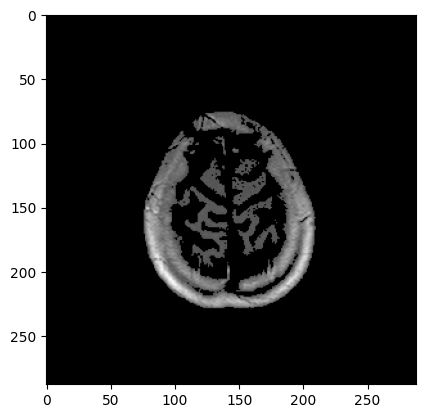

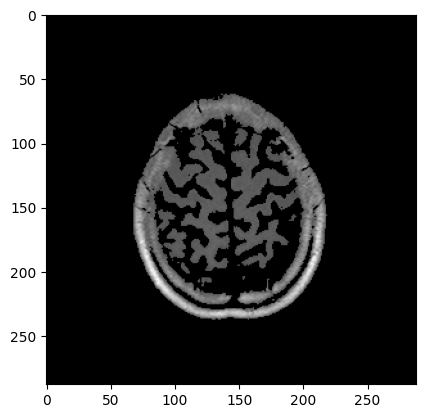

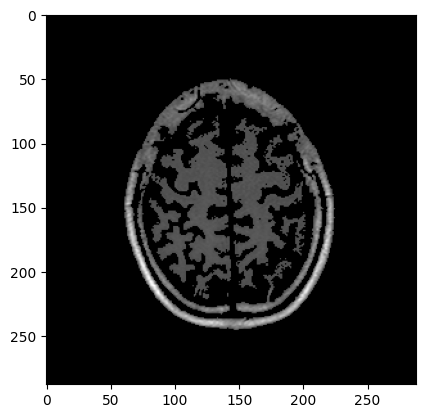

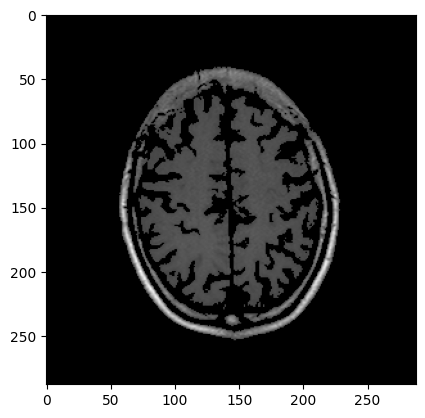

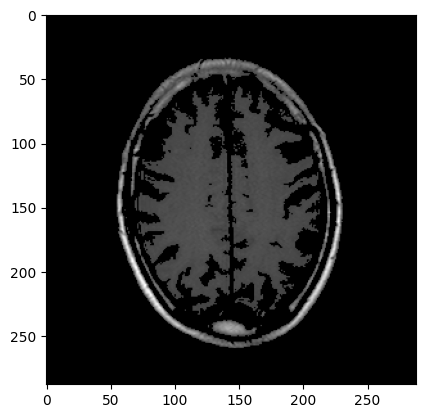

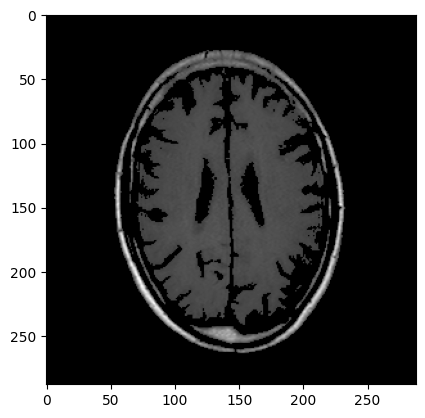

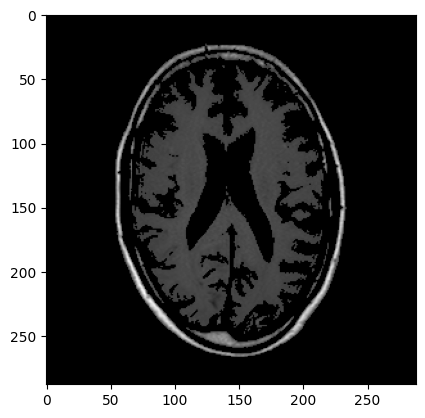

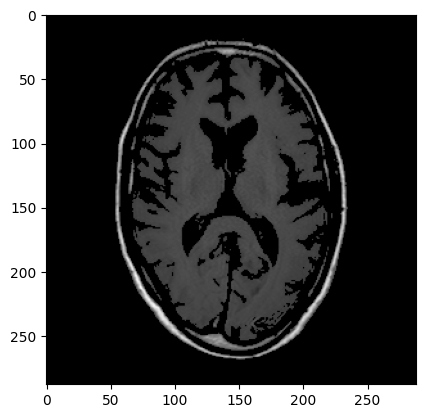

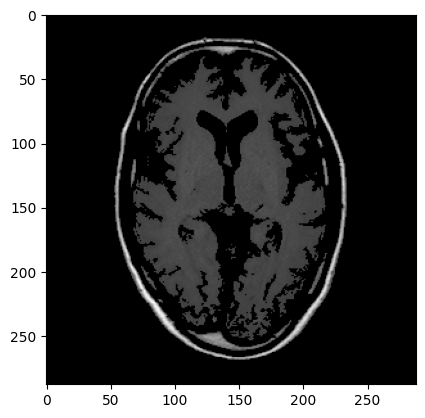

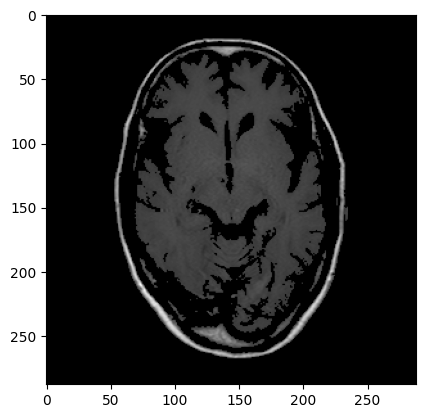

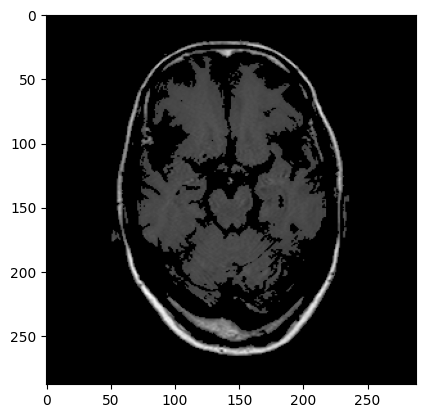

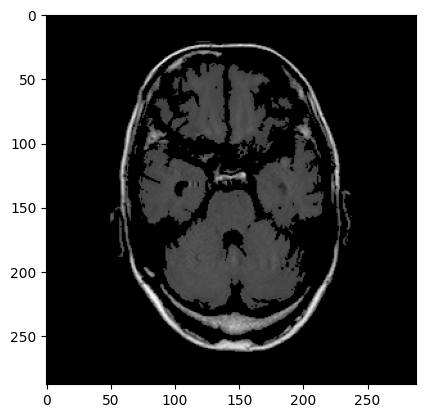

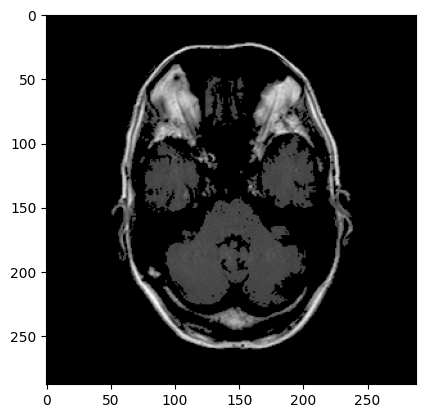

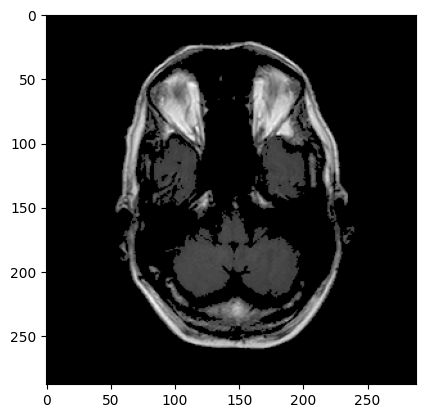

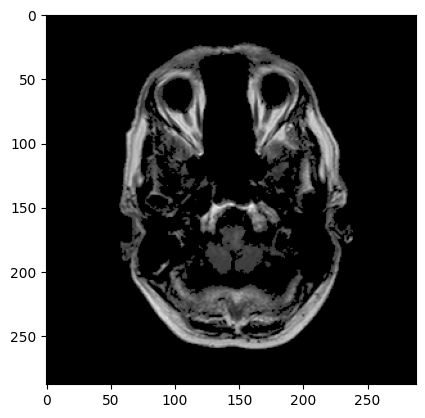

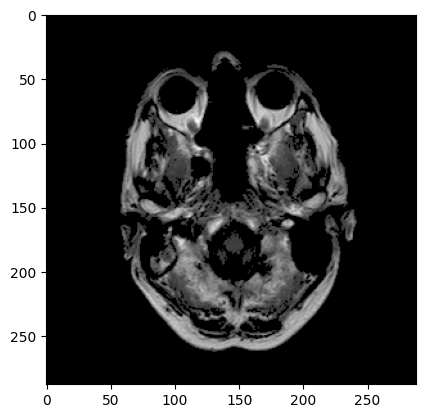

In [45]:
import nibabel as nib
import numpy as np
from nilearn.image import new_img_like
from skimage import morphology, measure
from scipy.ndimage import binary_fill_holes

def skull_strip(input_nifti_path, output_nifti_path, brain_mask_threshold = 220):
    # Load the input NIfTI image
    input_nifti = nib.load(input_nifti_path)
    input_data = input_nifti.get_fdata()

    # Create a binary mask for the brain using intensity thresholding
    binary_mask = input_data > brain_mask_threshold

    # Perform morphological operations to remove small objects and fill holes
    cleaned_mask = morphology.remove_small_objects(binary_mask, min_size=500)
    cleaned_mask = binary_fill_holes(cleaned_mask)

    # Label connected regions
    labeled_mask, num_features = measure.label(cleaned_mask, return_num=True)

    # Find the largest connected component, assuming it's the brain
    largest_component = None
    max_size = 0
    for region in measure.regionprops(labeled_mask):
        if region.area > max_size:
            max_size = region.area
            largest_component = region

    # Create a mask for the largest connected component (brain)
    brain_mask = labeled_mask == largest_component.label

    # Apply the brain mask to the input image to get the skull-stripped image
    skull_stripped_data = input_data * brain_mask

    # Create a new NIfTI image with the skull-stripped data
    skull_stripped_nifti = new_img_like(input_nifti, skull_stripped_data)

    # Save the skull-stripped NIfTI image
    nib.save(skull_stripped_nifti, output_nifti_path)

    print(f"Skull stripping completed. Output saved as '{output_nifti_path}'.")


# Example usage
input_nifti_path = '/content/drive/MyDrive/IAAA-Challenge/nifti/1.3.46.670589.11.10042.5.0.1412.2024020313401387235.nii.gz'
output_nifti_path = '/content/drive/MyDrive/IAAA-Challenge/nifti2/sss-1.3.46.670589.11.10042.5.0.1412.2024020313401387235.nii.gz'
skull_strip(input_nifti_path, output_nifti_path)

import matplotlib.pyplot as plt

for slicen in range(img.shape[2]) :
  img = nib.load(output_nifti_path).get_fdata()
  plt.imshow(img[:, :, slicen], cmap='gray')  # Show one slice of the original image
  plt.show()

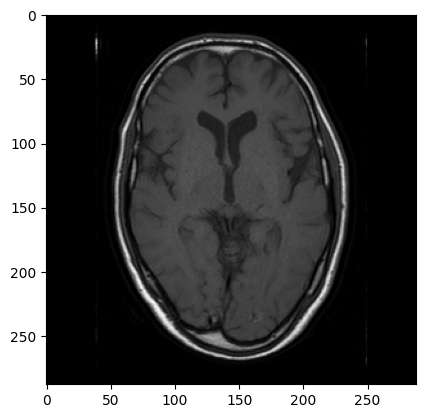

In [ ]:
import os
import pydicom
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import skimage
from skimage import filters, morphology
import SimpleITK as sitk

# Function to read DICOM files and convert them to a 3D numpy array
def read_dicom_series(directory):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(directory)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    array = sitk.GetArrayFromImage(image)
    return array, image

# Function to extract brain using a simple threshold and morphological operations
def extract_brain(image_array):
    # Apply a threshold to extract brain (example using Otsu's method)
    threshold = filters.threshold_otsu(image_array)
    binary_image = image_array > threshold

    # Morphological operations to remove small objects and fill holes
    cleaned_image = morphology.remove_small_objects(binary_image, min_size=100)
    cleaned_image = morphology.binary_closing(cleaned_image, morphology.ball(2))
    return cleaned_image

# Function to register brain to an atlas
def register_to_atlas(moving_image, atlas_image):
    # Convert numpy arrays to SimpleITK images
    moving_sitk = sitk.GetImageFromArray(moving_image.astype(np.float32))
    atlas_sitk = sitk.GetImageFromArray(atlas_image.astype(np.float32))

    # Perform registration
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMeanSquares()
    registration_method.SetOptimizerAsRegularStepGradientDescent(1.0, .01, 200)
    registration_method.SetInitialTransform(sitk.TranslationTransform(atlas_sitk.GetDimension()))
    registration_method.SetInterpolator(sitk.sitkLinear)

    final_transform = registration_method.Execute(atlas_sitk, moving_sitk)
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(atlas_sitk)
    resampler.SetTransform(final_transform)
    resampler.SetInterpolator(sitk.sitkLinear)

    registered_image = resampler.Execute(moving_sitk)
    registered_array = sitk.GetArrayFromImage(registered_image)
    return registered_array

# Main process
def process_dicom_series(directory, atlas_path):
    # Read DICOM series
    image_array, image = read_dicom_series(directory)

    # Extract brain from the image
    brain_image = extract_brain(image_array)

    # Load atlas image
    atlas_nifti = nib.load(atlas_path)
    atlas_array = atlas_nifti.get_fdata()

    # Register brain image to the atlas
    registered_image = register_to_atlas(brain_image, atlas_array)

    # Save the registered image as a NIfTI file
    registered_nifti = nib.Nifti1Image(registered_image, atlas_nifti.affine)
    nib.save(registered_nifti, 'registered_brain.nii.gz')

    print("Brain extraction and registration completed. Output saved as 'registered_brain.nii.gz'.")

# Example usage
dicom_directory = files[0]
atlas_file = 'path/to/atlas.nii.gz'
process_dicom_series(dicom_directory, atlas_file)


In [ ]:
import os
import pydicom
import matplotlib.pyplot as plt

# Function to get the slice location from a DICOM file
def get_slice_location(dicom_path):
    dicom_data = pydicom.dcmread(dicom_path)
    slice_location_tag = (0x0020, 0x1041)
    try:
        return dicom_data[slice_location_tag].value
    except KeyError:
        return None

# Function to read the image data from a DICOM file
def get_image_data(dicom_path):
    dicom_data = pydicom.dcmread(dicom_path)
    return dicom_data.pixel_array

for filee in files:
  # Specify the directory containing the DICOM files
  dicom_directory = filee

  # Create a dictionary to store the file paths and their slice locations
  slices_dict = {}

  # Iterate through the files in the directory
  for root, dirs, files in os.walk(dicom_directory):
      for file in files:
          if file.endswith('.dcm'):
              file_path = os.path.join(root, file)
              slice_location = get_slice_location(file_path)
              if slice_location is not None:
                  slices_dict[file_path] = slice_location

  # Sort the dictionary based on slice location
  sorted_slices_dict = dict(sorted(slices_dict.items(), key=lambda item: item[1]))

  # Get the sorted file paths
  sorted_file_paths = list(sorted_slices_dict.keys())

  # Create a figure with a 4x5 grid of subplots
  fig, axes = plt.subplots(4, 5, figsize=(15, 12))
  fig.suptitle('DICOM Slices Sorted by Slice Location')

  # Plot each slice in the grid
  for i, file_path in enumerate(sorted_file_paths):
      if i >= 20:  # Limit to 20 images for the 4x5 grid
          break
      row = i // 5
      col = i % 5
      image_data = get_image_data(file_path)
      axes[row, col].imshow(image_data, cmap='gray')
      axes[row, col].set_title(f'Slice {i+1}')
      axes[row, col].axis('off')

  # Adjust layout and display the plot
  plt.tight_layout()
  plt.subplots_adjust(top=0.9)
  plt.show()


In [ ]:
import os
import pydicom
import matplotlib.pyplot as plt
import pandas as pd
meta_df = pd.DataFrame()

# Function to extract all metadata from a DICOM file and return as a dictionary
def extract_metadata(dicom_path):
    dicom_data = pydicom.dcmread(dicom_path)
    metadata = {}
    for elem in dicom_data:
        if elem.VR != 'SQ':  # Skip sequences
            metadata[elem.name] = elem.value
        else:
            metadata[elem.name] = 'Sequence'
    return metadata

metadata_list = []

for filee in files:
  image_paths = glob.glob(filee+"/*.dcm")
  metadata_dict = extract_metadata(image_paths[0])
  metadata_list.append(metadata_dict)

meta_df = pd.DataFrame(metadata_list)
meta_df = meta_df.dropna()
meta_df = meta_df.loc[:, (meta_df != meta_df.iloc[0]).any()]
meta_df.to_csv("/content/drive/MyDrive/Projects/Ongoing Projects/IAAA-Challenge/Data/meta-data-2.csv")



In [ ]:
import pydicom
from pydicom.data import get_testdata_file
ق
metadata_list = []


def extract_important_metadata(dicom_path):
    # Load the DICOM file
    dicom_data = pydicom.dcmread(dicom_path)

    # Define the most important DICOM tags
    important_tags = {
        'PatientID': ('0010','0020'),
        'PatientName': ('0010','0010'),
        'PatientBirthDate': ('0010','0030'),
        'PatientSex': ('0010','0040'),
        'StudyDate': ('0008','0020'),
        'StudyTime': ('0008','0030'),
        'Modality': ('0008','0060'),
        'Manufacturer': ('0008','0070'),
        'InstitutionName': ('0008','0080'),
        'ReferringPhysicianName': ('0008','0090'),
        'StudyDescription': ('0008','1030'),
        'SeriesDescription': ('0008','103e'),
        'PatientAge': ('0010','1010'),
        'BodyPartExamined': ('0018','0015'),
        'SliceThickness': ('0018','0050'),
        'KVP': ('0018','0060'),
        'SeriesNumber': ('0020','0011'),
        'AcquisitionNumber': ('0020','0012'),
        'InstanceNumber': ('0020','0013'),
        'ImagePositionPatient': ('0020','0032'),
        'ImageOrientationPatient': ('0020','0037'),
        'SliceLocation': ('0020','1041'),
        'PixelSpacing': ('0028','0030')
    }

    # Extract the metadata
    metadata = {}
    for tag_name, tag in important_tags.items():
        if tag in dicom_data:
            metadata[tag_name] = dicom_data[tag].value
        else:
            metadata[tag_name] = 'N/A'

    return metadata

for filee in files:
  image_paths = glob.glob(filee+"/*.dcm")
  metadata = extract_important_metadata(image_paths[0])
  metadata_list.append(metadata)

mmeta_df = pd.DataFrame(metadata_list)

# Save to a CSV file
mmeta_df.to_csv('important_dicom_metadata.csv', index=False)